In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose   # para descomponer la serie temporal de precios en componentes de tendencia, estacionalidad y ruido.
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

import sys
import os

# IMPORTANTE - asegurarse de que el path es el correcto, tiene que apuntar a la carpeta Tools (o equivalente si se le cambia el nombre, debería ser Tools)

tools_path = os.path.abspath('./Tools')

# Comprobar si existe la carpeta Tools
if os.path.exists(tools_path):
    sys.path.append(tools_path)
else:
    print("The Tools directory does not exist. Please check the path.")
# importamos toolkit.py
try:
    from toolkit import procesar_datos_avocado  
    from toolkit import regresion_modelos
    from toolkit import formatear_resultados
except ImportError as e:  # Catch ImportError para ver si hay errores al importar
    print(f"ImportError: {e}. comprueba que 'process_dataset' exista en 'toolkit.py'.")


data_avo=procesar_datos_avocado('/home/jose/avocado/Avocado/avocado.csv','B')
data_avo['Date'] = pd.to_datetime(data_avo['Date'])


 




In [ ]:
# 1.1 Descomposición de Series Temporales de Precios:
  ##  Analisis previo de los datos para determinar con cuales regiones trabajamos 

''' Para gran parte del proyecto utilizaremos regiones_geograficas mas California  
regiones_geograficas = ["California", "GreatLakes", "Midsouth", "Northeast", "Plains", "SouthCentral", "Southeast", "West"] ya 
que representan la suma del TotalUs y nos proporcinan una muestrare presentativa de los datos de US '''

 - Uso de Datos: Usa la columna AveragePrice y Date.
 - Esperado: Utiliza la función seasonal_decompose de la librería statsmodels para descomponer la serie temporal de precios en componentes de tendencia, estacionalidad y ruido.
 - Convierte Date a tipo datetime usando pd.to_datetime().
 - Agrupa los datos por Date y calcula el promedio de AveragePrice utilizando groupby() si es necesario.
 - Visualiza los componentes descompuestos usando matplotlib para cada uno de ellos.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          169 non-null    datetime64[ns]
 1   AveragePrice  169 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.8 KB
#----------------------------------------------------------------------------------------------------


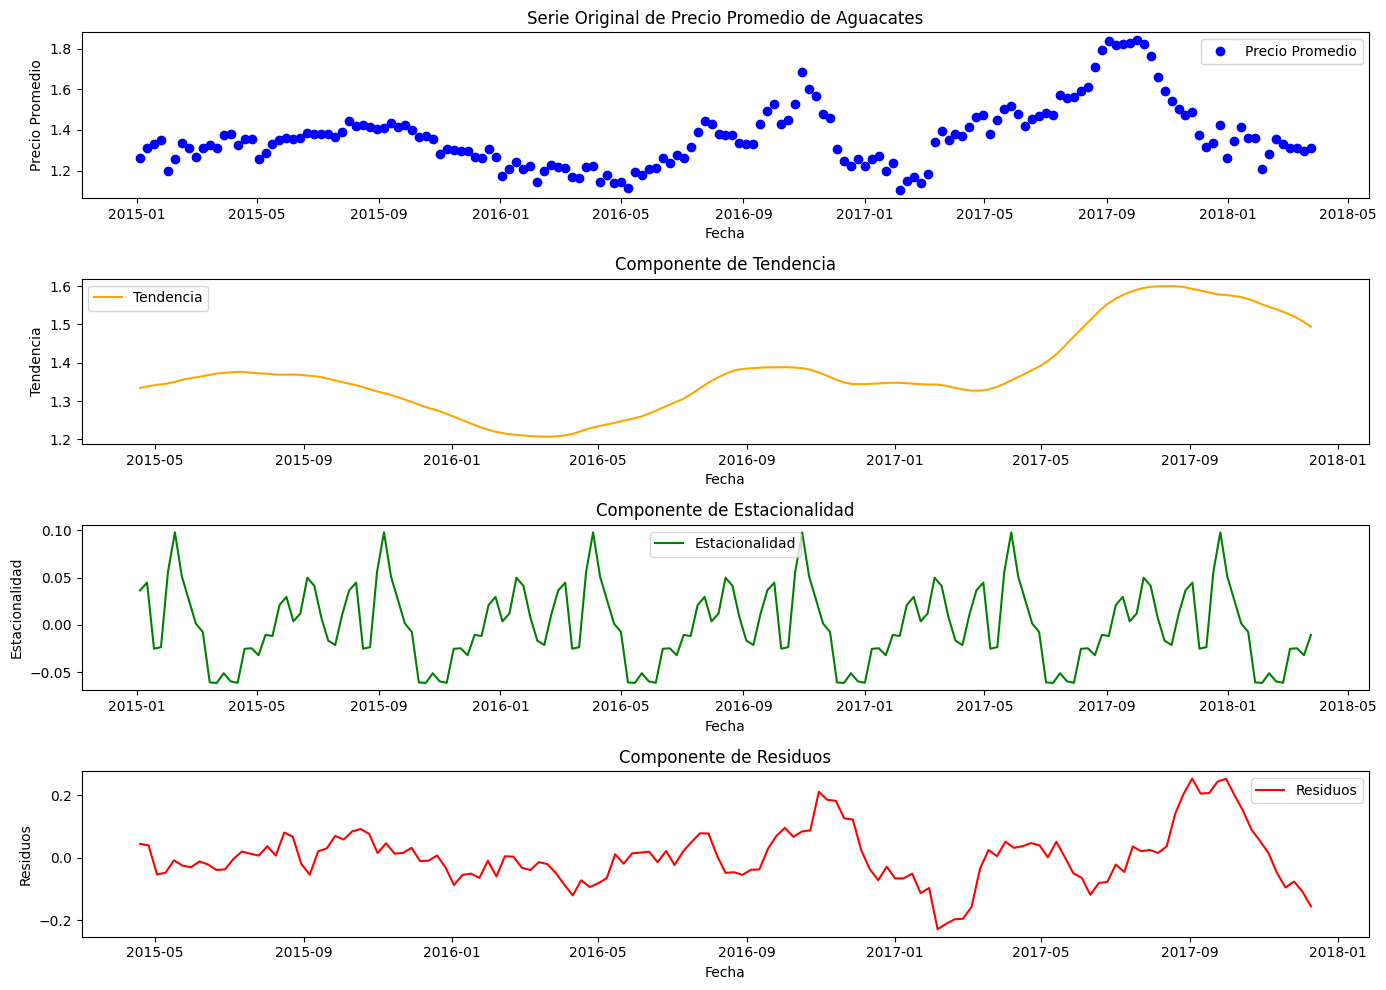

In [4]:
data_avo['Date'] = pd.to_datetime(data_avo['Date'])
data_avo.dtypes 

promedio_precio = data_avo.groupby('Date')['AveragePrice'].mean().reset_index()
promedio_precio.info()

print("#"+ '-'*100) 
# Establecer Date como índice y especificar la frecuencia
promedio_precio.set_index('Date', inplace=True)


if promedio_precio['AveragePrice'].isnull().any():
    print("Valores nulos encontrados. Procediendo a manejarlos.")
    promedio_precio = promedio_precio.dropna()

# Descomponer la serie temporal en componentes de tendencia, estacionalidad y residuos.
result = seasonal_decompose(promedio_precio['AveragePrice'], model='additive',period=30)

# Crear gráficos para los componentes
plt.figure(figsize=(14, 10))

# Gráfico de la serie original
plt.subplot(4, 1, 1)
plt.plot(promedio_precio['AveragePrice'],marker='o', linestyle='', label='Precio Promedio', color='blue')
plt.title('Serie Original de Precio Promedio de Aguacates')
plt.xlabel('Fecha')
plt.ylabel('Precio Promedio')
plt.legend()

# Gráfico de la tendencia
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Tendencia', color='orange')
plt.title('Componente de Tendencia')
plt.xlabel('Fecha')
plt.ylabel('Tendencia')
plt.legend()

# Gráfico de la estacionalidad
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Estacionalidad', color='green')
plt.title('Componente de Estacionalidad')
plt.xlabel('Fecha')
plt.ylabel('Estacionalidad')
plt.legend()

# Gráfico de los residuos
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuos', color='red')
plt.title('Componente de Residuos')
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.legend()

# Ajustar el layout
plt.tight_layout()
plt.show()


# 1.2. Análisis de Estacionalidad por Región:
 - Uso de Datos: Usa las columnas AveragePrice, Date y Total Volume.
 - Esperado: Utiliza gráficos de líneas para visualizar cómo varían los precios de aguacates por región a lo largo de diferentes estaciones del año.
 - Agrupa los datos por region y Date utilizando groupby().
 - Calcula el promedio de AveragePrice para cada región.
 - Representa gráficamente las tendencias utilizando plt.plot() de matplotlib.

AveragePrice    0
Total Volume    0
dtype: int64


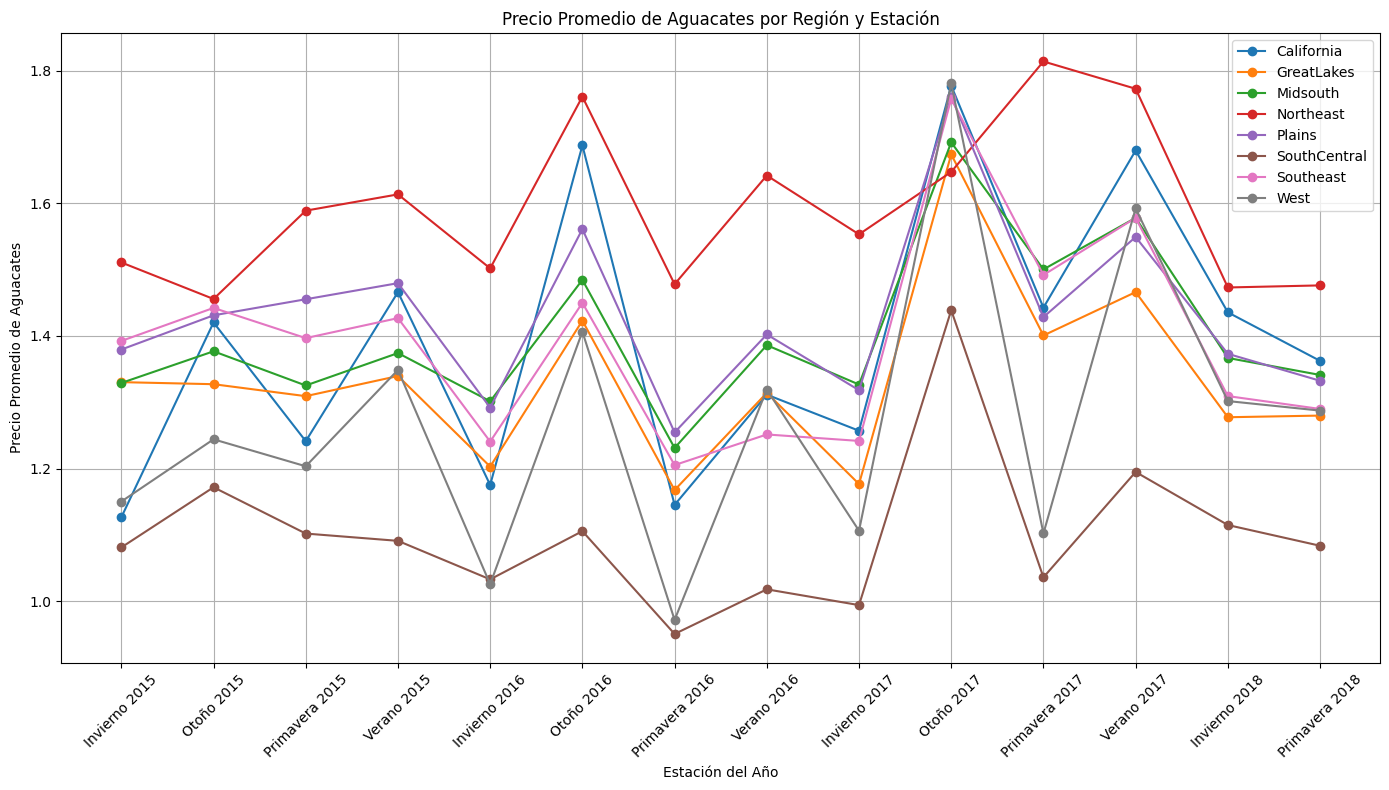

In [6]:
# Añadir una columna para la estación del año

def obtener_estacion(fecha):
    if fecha.month in [12, 1, 2]:
        return 'Invierno'
    elif fecha.month in [3, 4, 5]:
        return 'Primavera'
    elif fecha.month in [6, 7, 8]:
        return 'Verano'
    else:
        return 'Otoño'

# se crea nueva columna
data_avo['Estacion'] = data_avo['Date'].apply(obtener_estacion)


# Calcular el promedio de AveragePrice por región y estación
promedio_por_estacion = data_avo.groupby(['region','year', 'Estacion'])['AveragePrice'].mean().reset_index()


# Verificar si hay valores nulos en AveragePrice o Total Volume
print(data_avo[['AveragePrice', 'Total Volume']].isnull().sum())

# Calcular el promedio de 'AveragePrice' para cada región
promedio_precio_region = data_avo.groupby('region', as_index=False)['AveragePrice'].mean()


# Graficar los datos

# Graficar cada región con un color diferente

plt.figure(figsize=(14, 8))
for region, group in promedio_por_estacion.groupby('region'):
    group['Estacion'] = group['Estacion'] + ' ' + group['year'].astype(str)
    plt.plot(group['Estacion'], group['AveragePrice'], label=region, marker='o')

# Añadir títulos y etiquetas
plt.title('Precio Promedio de Aguacates por Región y Estación')
plt.xlabel('Estación del Año')
plt.ylabel('Precio Promedio de Aguacates')
plt.xticks(rotation=45)  # rotar las etiquetas del eje x
plt.legend()
plt.grid()
plt.tight_layout()  # Ajustar el diseño para que no se corten los elementos

# Mostrar el gráfico
plt.show()

In [ ]:
# 2.1 Gráfico de Violín de Volumen de Ventas por Región:

 - Uso de Datos: Usa las columnas Total Volume y region.
 - Esperado: Visualiza la distribución de ventas en diferentes regiones.
 - Utiliza la función violinplot de seaborn para crear gráficos de violín.
 - Configura los ejes para mostrar la relación entre Total Volume y region.
 - Añade etiquetas y títulos usando plt.title() y plt.xlabel() para facilitar la interpretación.

/tmp/ipykernel_289161/499934458.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='region', y='Total Volume', data=data_avo,palette='Set1')  # ,inner='quartile'


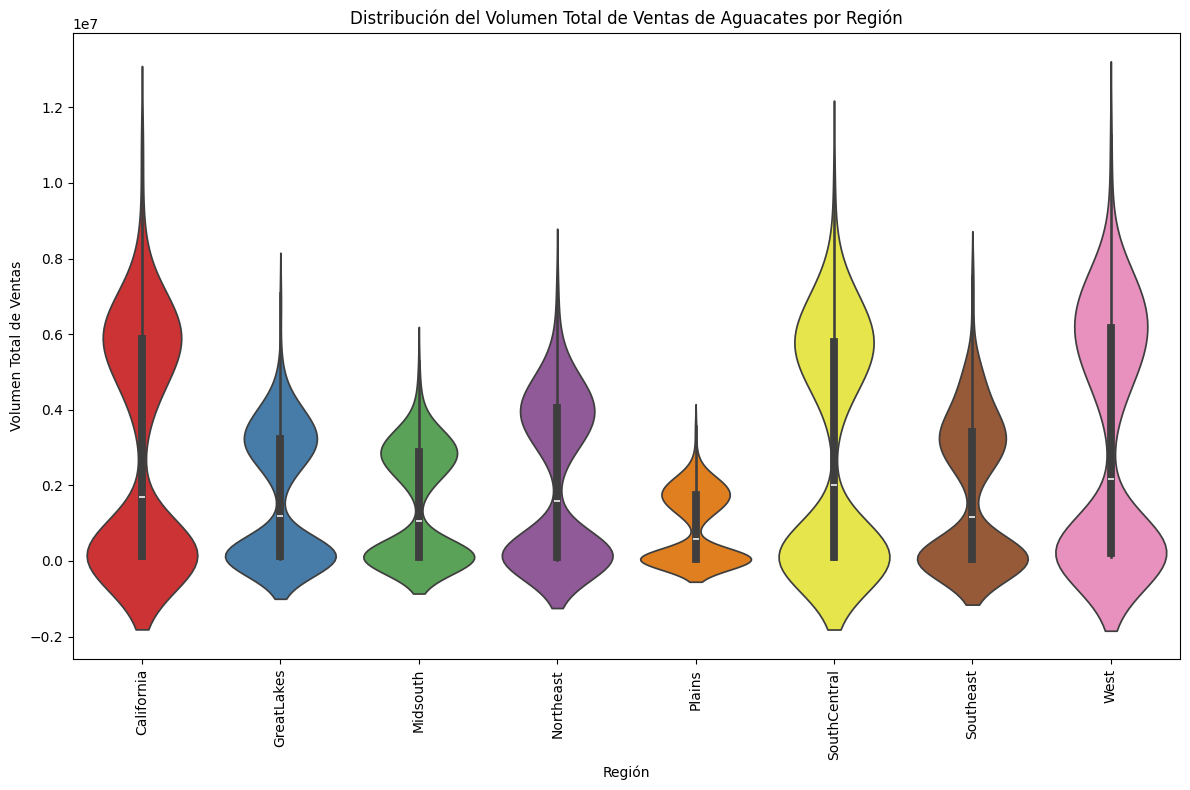

In [16]:
data_avo['Date'] = pd.to_datetime(data_avo['Date'])

# Crear el gráfico de violín usando seaborn
plt.figure(figsize=(12, 8))
sns.violinplot(x='region', y='Total Volume', data=data_avo,palette='Set1')  # ,inner='quartile'

# Configurar etiquetas y títulos
plt.title('Distribución del Volumen Total de Ventas de Aguacates por Región')
plt.xlabel('Región')
plt.ylabel('Volumen Total de Ventas')

# Rotar las etiquetas del eje x para facilitar la lectura si hay muchas regiones
plt.xticks(rotation=90)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# 2.2 Boxplot Comparativo de Precios entre Años:

 - Uso de Datos: Usa las columnas AveragePrice y year.
 - Esperado: Genera boxplots para comparar la distribución de precios.
 - Utiliza boxplot de seaborn para crear boxplots que comparen AveragePrice entre diferentes años.
 - Asegúrate de que cada boxplot represente un año diferente.
 - Incluye etiquetas y títulos descriptivos usando plt.title().

/tmp/ipykernel_289161/2127674105.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  precio_promedio_mes = data_avo.groupby(pd.Grouper(key='Date', freq='M'))['AveragePrice'].mean().reset_index()
/tmp/ipykernel_289161/2127674105.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='year', y='AveragePrice', data=precio_promedio_mes, palette='Set1')


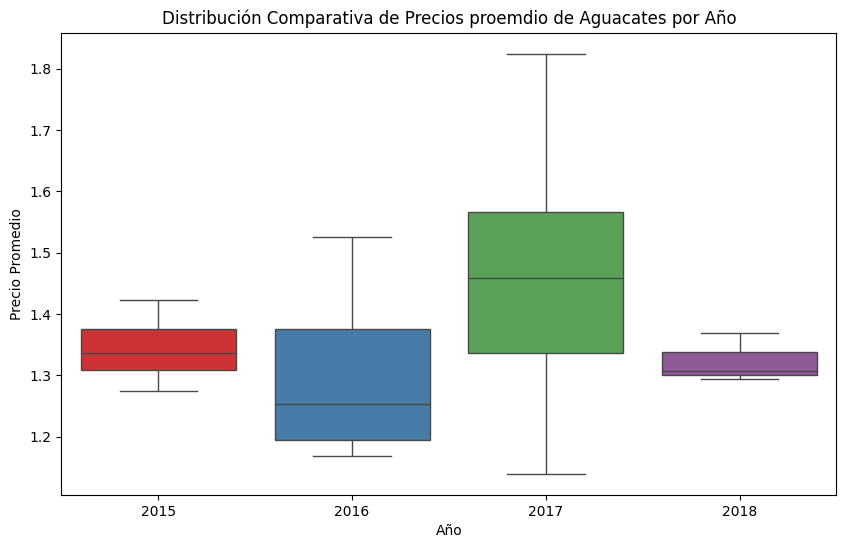

In [20]:
# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Agrupar por mes y calcular el precio promedio
precio_promedio_mes = data_avo.groupby(pd.Grouper(key='Date', freq='M'))['AveragePrice'].mean().reset_index()

# Agregar una columna 'year' 
precio_promedio_mes['year'] = precio_promedio_mes['Date'].dt.year

# Crear el boxplot comparativo de precios entre años
sns.boxplot(x='year', y='AveragePrice', data=precio_promedio_mes, palette='Set1')
    
# Añadir título y etiquetas de ejes
plt.title('Distribución Comparativa de Precios proemdio de Aguacates por Año')
plt.xlabel('Año')
plt.ylabel('Precio Promedio')
    
# Mostrar el gráfico
plt.show()

### 3. **Elasticidad del Precio**
**Resumen:** El análisis de elasticidad precio-demanda permite evaluar cómo los cambios en los precios afectan la demanda de aguacates. Comprender la elasticidad puede ayudar a formular estrategias de precios más efectivas.

La fórmula de elasticidad precio-demanda es:

$$
E_d = \frac{\% \text{Cambio en la cantidad demandada}}{\% \text{Cambio en el precio}} = \frac{\Delta Q / Q}{\Delta P / P}
$$

3.1. **Elasticidad Precio-Demanda por Año:**
   - **Uso de Datos:** Usa las columnas `AveragePrice` y `Total Volume`.
   - **Esperado:** Calcula la elasticidad del precio de la demanda para cada año.
     - Calcula la variación porcentual de `Total Volume` y `AveragePrice` utilizando `pd.pct_change()`.
     - Utiliza la fórmula de elasticidad para determinar la sensibilidad de la demanda respecto al precio.
     - Presenta los resultados en un gráfico de líneas usando `plt.plot()` para mostrar la elasticidad por año.


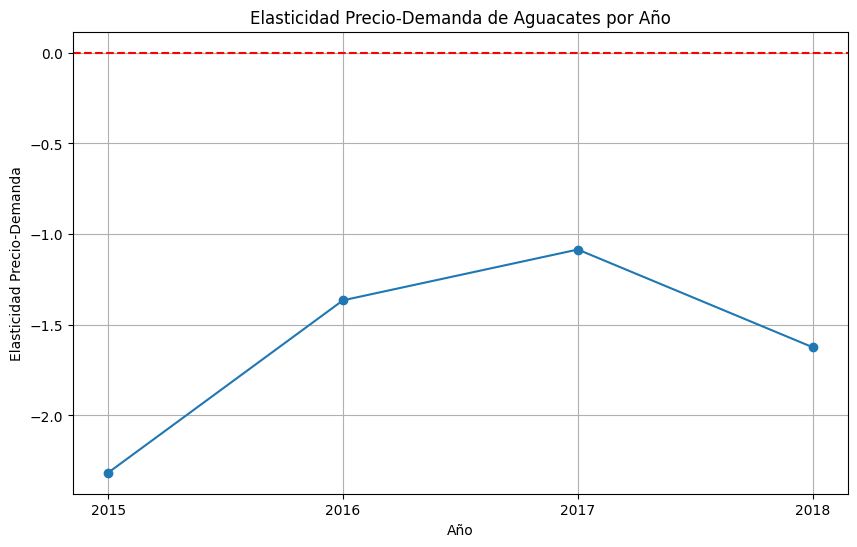

In [23]:
data_avo['Date'] = pd.to_datetime(data_avo['Date'])


# Extraer el año de la columna Date
data_avo['Year'] = data_avo['Date'].dt.year

# Calcular variación porcentual de AveragePrice y Total Volume
data_avo['Cambio Precio (%)'] = data_avo['AveragePrice'].pct_change()
data_avo['Cambio Volume (%)'] = data_avo['Total Volume'].pct_change()


# Calcular la elasticidad precio-demanda
data_avo['Elasticity'] = data_avo['Cambio Volume (%)'] / data_avo['Cambio Precio (%)']

# Eliminar NaN y valores infinitos en la columna Elasticity
data_avo = data_avo[np.isfinite(data_avo['Elasticity'])]  # Mantiene solo las filas donde Elasticity no es NaN ni infinito

# Agrupar por año y calcular la elasticidad promedio
elasticity_por_a = data_avo.groupby('Year')['Elasticity'].mean().reset_index()

# Graficar la elasticidad por año
plt.figure(figsize=(10, 6))
plt.plot(elasticity_por_a['Year'], elasticity_por_a['Elasticity'], marker='o')
plt.title('Elasticidad Precio-Demanda de Aguacates por Año')
plt.xlabel('Año')
plt.ylabel('Elasticidad Precio-Demanda')
plt.axhline(0, color='red', linestyle='--')  # Línea horizontal en y=0
plt.grid(True)
plt.xticks(elasticity_por_a['Year'])  # Asegura que todos los años se muestren en el eje x
plt.show()

2. **Comparación de Elasticidad en Diferentes Mercados:**
   - **Uso de Datos:** Utiliza las columnas `Total Volume` y `AveragePrice`.
   - **Esperado:** Calcula la elasticidad del precio de la demanda en diferentes regiones.
     - Agrupa los datos por `region` y calcula la elasticidad para cada región utilizando `pd.pct_change()`.
     - Presenta un gráfico de barras que muestre la elasticidad por región usando `plt.bar()`.

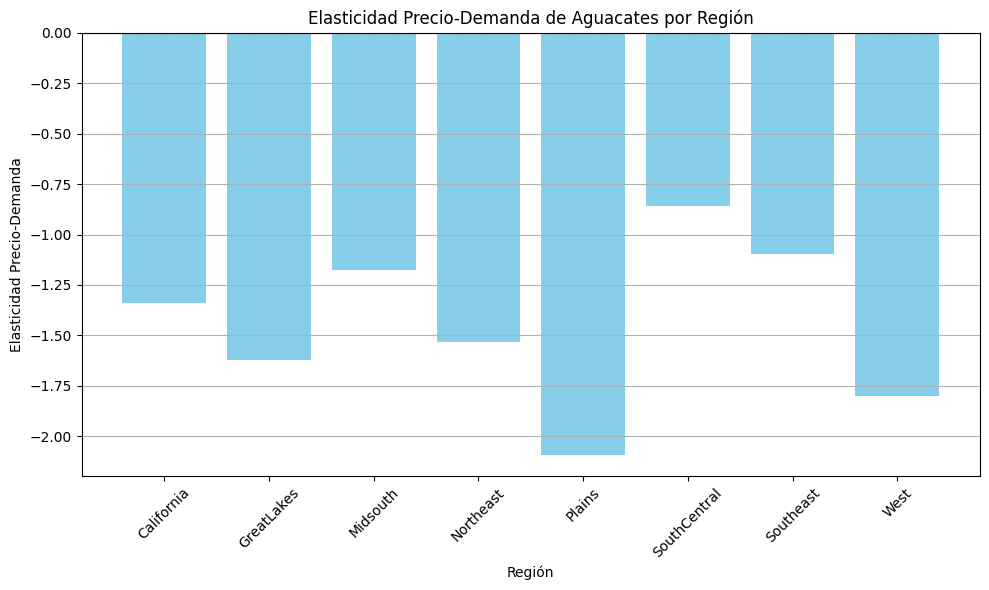

In [26]:
# Agrupar por región
regions = data_avo.groupby('region')

# Crear un DataFrame para almacenar la elasticidad por región
elasticity_data = []

# Calcular elasticidad para cada región
for region, group in regions:
    # Calcular variaciones porcentuales de AveragePrice y Total Volume
    group['Price Change (%)'] = group['AveragePrice'].pct_change()
    group['Volume Change (%)'] = group['Total Volume'].pct_change()
    
    # Calcular elasticidad precio-demanda
    group['Elasticity'] = group['Volume Change (%)'] / group['Price Change (%)']
    
    # Eliminar NaN y valores infinitos en la columna Elasticity
    group = group[np.isfinite(group['Elasticity'])]  # Mantiene solo las filas válidas
    
    # Calcular la elasticidad promedio para la región
    avg_elasticity = group['Elasticity'].mean()
    elasticity_data.append({'Region': region, 'Elasticity': avg_elasticity})

# Convertir la lista a un DataFrame
elasticity_df = pd.DataFrame(elasticity_data)

# Graficar la elasticidad por región
plt.figure(figsize=(10, 6))
plt.bar(elasticity_df['Region'], elasticity_df['Elasticity'], color='skyblue')
plt.title('Elasticidad Precio-Demanda de Aguacates por Región')
plt.xlabel('Región')
plt.ylabel('Elasticidad Precio-Demanda')
plt.axhline(0, color='red', linestyle='--')  # Línea horizontal en y=0
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor legibilidad
plt.grid(axis='y')
plt.tight_layout()  # Ajustar el layout para evitar superposición
plt.show()

In [ ]:
### 4. **Análisis de Cohortes**
**Resumen:** El análisis de cohortes permite agrupar datos según características específicas y observar cómo se comportan a lo largo del tiempo. Se centra en cohortes de precios y ventas para entender las dinámicas del mercado.

4.1. **Cohortes Basadas en Precios Promedios Trimestrales:**
   - **Uso de Datos:** Usa las columnas `AveragePrice`, `Total Volume` y `Date`.
   - **Esperado:** Crea cohortes trimestrales y analiza cambios en precios y volúmenes.
     - Agrupa los datos por trimestre usando `pd.Grouper` con `freq='Q'`.
     - Calcula el promedio de `AveragePrice` y suma `Total Volume` para cada cohorte.
     - Visualiza los resultados en un gráfico de líneas que muestre la evolución de las cohortes.

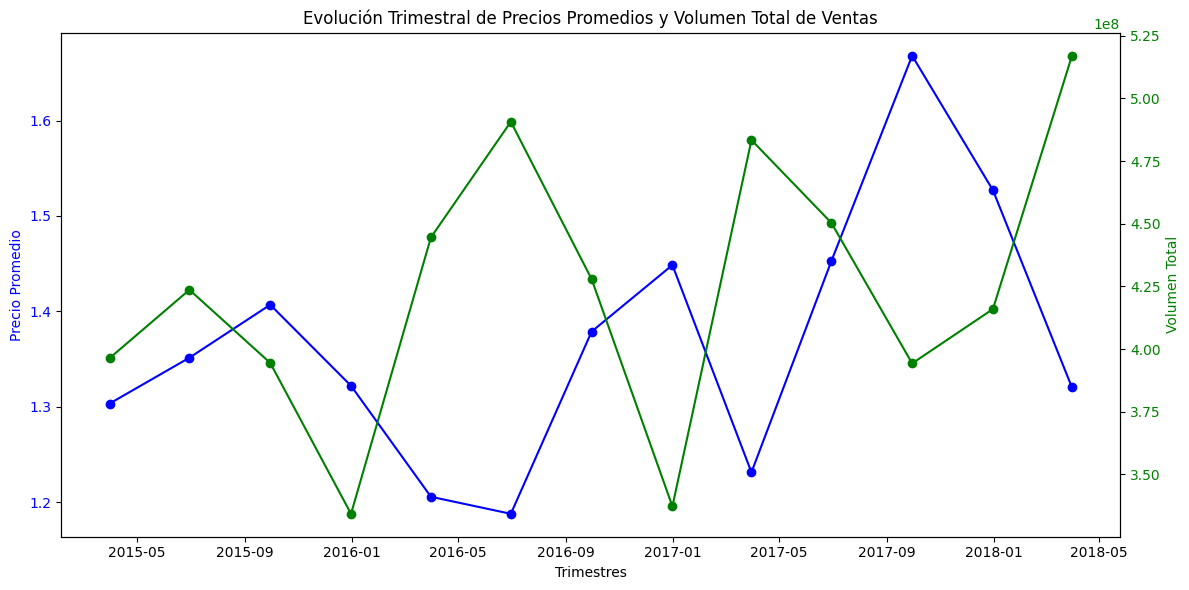

In [28]:
data_avo['Date'] = pd.to_datetime(data_avo['Date'])

# Agrupar por trimestre y calcular el promedio de precios y la suma de volúmenes
cohortes_trimestrales = data_avo.groupby(pd.Grouper(key='Date', freq='QE')).agg({
    'AveragePrice': 'mean',
    'Total Volume': 'sum'
}).reset_index()


# Crear el gráfico
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de la evolución de precios promedio en el eje y izquierdo
ax1.plot(cohortes_trimestrales['Date'], cohortes_trimestrales['AveragePrice'], color='blue', marker='o', label='Precio Promedio')
ax1.set_xlabel('Trimestres')
ax1.set_ylabel('Precio Promedio', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Evolución Trimestral de Precios Promedios y Volumen Total de Ventas')

# Crear el segundo eje y para el volumen total de ventas derecho 
ax2 = ax1.twinx()  # Crear un segundo eje y que comparte el eje x con el primero
ax2.plot(cohortes_trimestrales['Date'], cohortes_trimestrales['Total Volume'], color='green', marker='o', label='Volumen Total')
ax2.set_ylabel('Volumen Total', color='green')
ax2.tick_params(axis='y', labelcolor='green')


# Añadir leyendas y ajuste del layout
fig.tight_layout()  # Ajusta el layout para evitar superposición
plt.show()

In [ ]:
### 4.2. **Cohortes por Región y Fecha:**
   - **Uso de Datos:** Utiliza las columnas `AveragePrice`, `Total Volume`, `region` y `Date`.
   - **Esperado:** Analiza cómo varían las cohortes de diferentes regiones.
     - Agrupa los datos por `region` y `Date` usando `groupby()`.
     - Calcula el promedio de precios y volumen para cada cohorte.
     - Presenta los resultados en gráficos de barras que muestren comparaciones entre regiones.

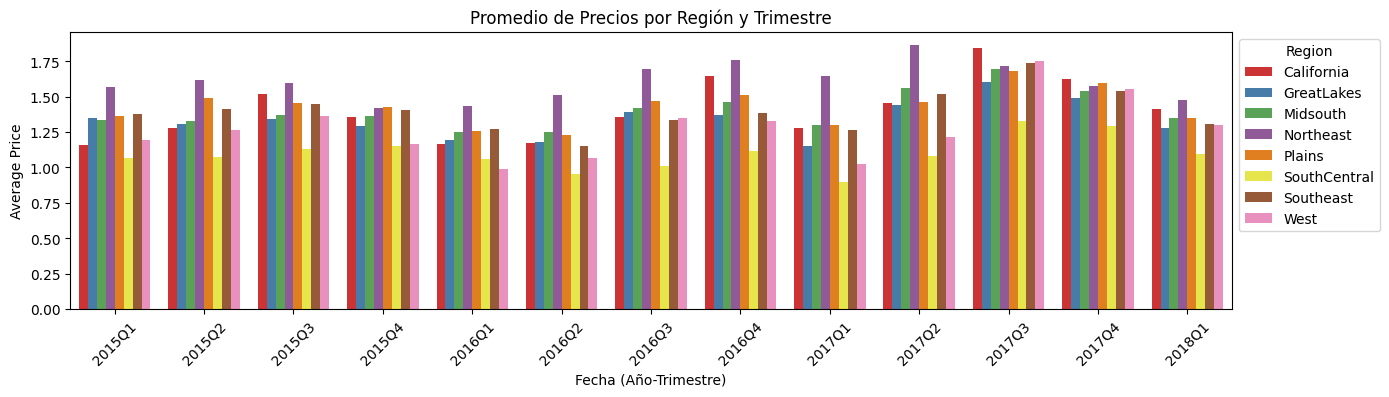

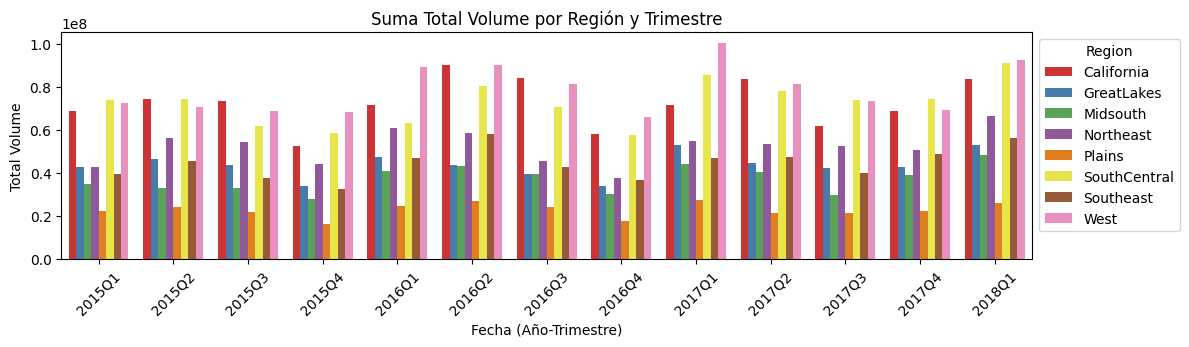

In [34]:
cohort_region = data_avo.groupby(['region', pd.Grouper(key='Date', freq='QE')]).agg({
    'AveragePrice': 'mean',
    'Total Volume': 'sum'
}).reset_index()

# Crear una columna para año y trimestre en formato 'YYYY-Tn' (T1, T2, T3, T4)
cohort_region['trimestre'] = cohort_region['Date'].dt.to_period('Q').astype(str)

# para la visualización
plt.figure(figsize=(14, 7))

# Gráfico de barras Average Price por región
plt.subplot(2, 1, 1)
sns.barplot(data=cohort_region, x='trimestre', y='AveragePrice', hue='region', palette='Set1')
plt.title('Promedio Precios por Región en cada Trimestre')
plt.xlabel('Fecha (Año-Trimestre)')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.legend(title='Region', loc='best', bbox_to_anchor=(1, 1))  # Adjust legend position
plt.tight_layout()


plt.figure(figsize=(12, 6))

# Gráfico de barras para Average Price para Total Volume
plt.subplot(2, 1, 1)
sns.barplot(data=cohort_region, x='trimestre', y='Total Volume', hue='region', palette='Set1')
plt.title('Suma Total Volume por Región y Trimestre')
plt.xlabel('Fecha (Año-Trimestre)')
plt.ylabel('Total Volume')
plt.xticks(rotation=45)
plt.legend(title='Region', loc='best', bbox_to_anchor=(1, 1))  # Adjust legend position
plt.tight_layout()

### 4.4 Cohortes de Clientes Basadas en Ventas:

Uso de Datos: Usa las columnas Total Volume, Date y region.
Esperado: Analiza el comportamiento de las cohortes según el volumen de ventas.
Clasifica los clientes según su volumen de compras.
Visualiza las cohortes en gráficos de líneas o barras que muestren el comportamiento de compra a lo largo del tiempo

/tmp/ipykernel_289161/2228844298.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_cohorts = data_avo.groupby(['Month', 'Cohorte'])['Total Volume'].sum().unstack().fillna(0)


<Figure size 1800x900 with 0 Axes>

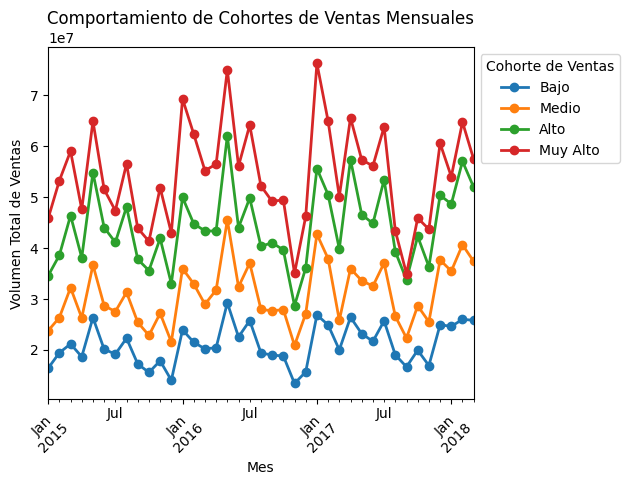

In [47]:
# Filtrar solo las columnas necesarias
data_avo = data_avo[['Date', 'region', 'Total Volume']]

# Clasificar las regiones en base al volumen de ventas total
# Agrupamos por región y calculamos el total de ventas
region_volume = data_avo.groupby('region')['Total Volume'].sum().reset_index()

# Clasificación de regiones en base a percentiles
# Definimos categorías en percentiles para crear cohortes
region_volume['Cohorte'] = pd.qcut(region_volume['Total Volume'], q=4, labels=['Bajo', 'Medio', 'Alto', 'Muy Alto'])

# Unir la clasificación con el conjunto de datos original
data_avo = data_avo.merge(region_volume[['region', 'Cohorte']], on='region', how='left')

# Crear cohortes mensuales y calcular el volumen total de ventas para cada cohorte y mes
data_avo['Month'] = data_avo['Date'].dt.to_period('M')  # Extraer mes y año
monthly_cohorts = data_avo.groupby(['Month', 'Cohorte'])['Total Volume'].sum().unstack().fillna(0)

# Visualización del comportamiento de compra a lo largo del tiempo
plt.figure(figsize=(18, 9))
monthly_cohorts.plot(kind='line', marker='o', linewidth=2, )
plt.title('Comportamiento de Cohortes de Ventas Mensuales')
plt.xlabel('Mes')
plt.ylabel('Volumen Total de Ventas')
# Colocar la leyenda fuera del gráfico
plt.legend(title='Cohorte de Ventas', loc='upper left', bbox_to_anchor=(1, 1)) 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_289161/1931536413.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_avg_volume_by_cohort = data_avo.groupby(['Month', 'Cohorte'])['Total Volume'].mean().unstack()


<Figure size 1200x600 with 0 Axes>

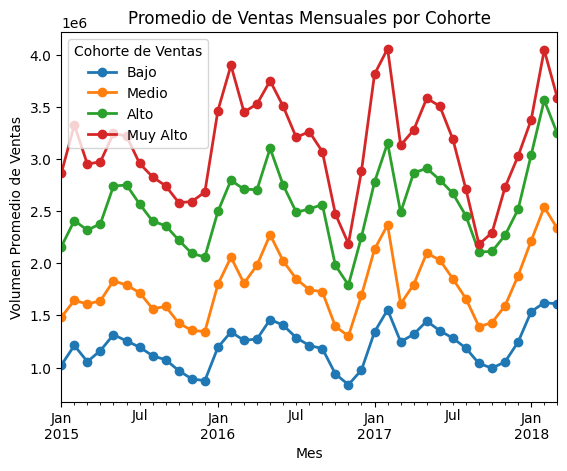

In [51]:
# Calcular el promedio mensual de ventas por cohorte
monthly_avg_volume_by_cohort = data_avo.groupby(['Month', 'Cohorte'])['Total Volume'].mean().unstack()

# Visualizar en un gráfico de líneas para ver la tendencia
plt.figure(figsize=(12, 6))
monthly_avg_volume_by_cohort.plot(kind='line', marker='o', linewidth=2)
plt.title('Promedio de Ventas Mensuales por Cohorte')
plt.xlabel('Mes')
plt.ylabel('Volumen Promedio de Ventas')
plt.legend(title='Cohorte de Ventas')
plt.show()